# 数据预处理

## 阶段 0：Notebook 环境就绪
| 步   | 目标                 | 操作要点                                                                                                                   |
| --- | ------------------ | ---------------------------------------------------------------------------------------------------------------------- |
| 0-1 | **在目录里开 Notebook** | 在终端 `jupyter notebook` → 打开浏览器 → 点击 “New → Python3”；文件名起 `01_preprocess.ipynb`                                         |
| 0-2 | **安装/导入必备库**       | 第一格：<br>`!pip install -U pandas opencv-python pillow albumentations tqdm`<br>然后 `import` 测试：`import cv2, pandas as pd` |

## 阶段 1：探索数据 → 清点文件
| 步   | 目标                  | 操作要点                                                                                                              |
| --- | ------------------- | ----------------------------------------------------------------------------------------------------------------- |
| 1-1 | **打印目录树**           | 在 Notebook 新 cell：<br>`import os, pprint; pprint.pprint(os.listdir('archive'))`                                   |
| 1-2 | **统计每个动作文件夹里的图片数量** | `for act in os.listdir('archive'):`<br>  `n = len(os.listdir(os.path.join('archive', act)))`<br>  `print(act, n)` |

## 阶段 2：生成索引 CSV
| 步   | 目标                        | 操作要点                                                                                                 |
| --- | ------------------------- | ---------------------------------------------------------------------------------------------------- |
| 2-1 | **写一个列表收集 (文件路径, label)** | 遍历各动作文件夹，把图片全路径和动作名写进 `rows = []`                                                                    |
| 2-2 | **用 pandas 保存为 CSV**      | `df = pd.DataFrame(rows, columns=['img_path','label']); df.to_csv('archive/index.csv', index=False)` |
| 2-3 | **读回 CSV 做 sanity check** | `pd.read_csv('archive/index.csv').head()`；确认路径正确                                                     |
## 设计 & 测试增广
| 步   | 目标                             | 操作要点                                                                                                                                   |
| --- | ------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------- |
| 3-1 | **搭建 Albumentations pipeline** | 新 cell：<br>`import albumentations as A, cv2, matplotlib.pyplot as plt`<br>写：`aug = A.Compose([...])`（先只用 `A.HorizontalFlip(p=0.5)` 测试） |
| 3-2 | **随机取一张图做增广并可视化**              | `sample = cv2.imread(df.iloc[0].img_path)`<br>`aug_img = aug(image=sample)["image"]`<br>`plt.imshow(aug_img[..., ::-1])`               |

## 阶段 4：批量处理并保存
| 步   | 目标               | 操作要点                                                                                                                                                                                          |
| --- | ---------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 4-1 | **建立输出目录**       | `out_dir = 'processed'; os.makedirs(out_dir, exist_ok=True)`                                                                                                                                  |
| 4-2 | **循环 CSV，保存增广图** | 用 `tqdm` 迭代 DataFrame；对每张：<br>  - 读图 → `aug(image=img)["image"]`<br>  - 新文件名：`f"{row.label}_{os.path.basename(row.img_path)}"`<br>  - `cv2.imwrite(os.path.join(out_dir, new_name), aug_img)` |
| 4-3 | **统计生成文件数量**     | `len(os.listdir('processed'))` 应≈原图数                                                                                                                                                          |

## 阶段 5：快速 DataLoader 验收
| 步   | 目标                               | 操作要点                                                                                                                                                   |
| --- | -------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------ |
| 5-1 | **用 torchvision ImageFolder 读取** | `from torchvision.datasets import ImageFolder; from torchvision import transforms`<br>`ds = ImageFolder('processed', transform=transforms.ToTensor())` |
| 5-2 | **随机取一个 batch 看 shape**          | `from torch.utils.data import DataLoader`<br>`dl = DataLoader(ds, batch_size=4); imgs, labels = next(iter(dl)); print(imgs.shape, labels)`             |

## 完成以上步骤后
- 目录 processed/ 里放的就是 遮挡 + 光照增强后的标准尺寸图片；
- archive/index.csv 仍保留原始索引，方便对比；
- Notebook 中每个 cell 都有输出，保证可复现。


In [23]:
import cv2, pandas as pd

## 阶段一：打印目录，统计图片数量

In [24]:
import os
from pprint import pprint

base_dir = './archive'
subdirs = os.listdir(base_dir)

print("子目录：")
pprint(subdirs)

子目录：
['hand_over',
 '.DS_Store',
 'eat_drink',
 'put_on_jacket',
 'fasten_seat_belt',
 'read_write_magazine',
 'read_write_newspaper',
 'final_task',
 'put_on_sunglasses',
 'work',
 'take_off_jacket',
 'take_off_sunglasses',
 'watch_video']


In [25]:
print("每个动作的图片数量:")

for action in sorted(subdirs):
    action_path = os.path.join(base_dir, action)
    if os.path.isdir(action_path):
        num_files = len(os.listdir(action_path))
        print(f"  - {action}: {num_files} 张图片")

每个动作的图片数量:
  - eat_drink: 38559 张图片
  - fasten_seat_belt: 10691 张图片
  - final_task: 9348 张图片
  - hand_over: 4036 张图片
  - put_on_jacket: 12174 张图片
  - put_on_sunglasses: 5671 张图片
  - read_write_magazine: 32829 张图片
  - read_write_newspaper: 29489 张图片
  - take_off_jacket: 7533 张图片
  - take_off_sunglasses: 5016 张图片
  - watch_video: 49409 张图片
  - work: 39024 张图片


## 阶段二：生成csv索引

In [26]:
import pandas as pd

rows = []

for action in sorted(subdirs):
    action_path = os.path.join(base_dir, action)
    if os.path.isdir(action_path):
        file_list = sorted(
            [f for f in os.listdir(action_path) if f.endswith('.jpg')],
            key=lambda x: int(x.split('_')[-1].split('.')[0])
        )
        for fname in file_list:
            img_path = os.path.join(action_path, fname)
            rows.append({'img_path': img_path, 'label': action})

print(f" 共收集到 {len(rows)} 张图片记录")

 共收集到 243779 张图片记录


In [27]:
df = pd.DataFrame(rows)
df.to_csv('index.csv', index=False)

print(" 已保存 index.csv")


 已保存 index.csv


In [28]:
df_check = pd.read_csv('index.csv')
print(df_check.head())

                          img_path      label
0  ./archive/eat_drink/image_0.jpg  eat_drink
1  ./archive/eat_drink/image_1.jpg  eat_drink
2  ./archive/eat_drink/image_2.jpg  eat_drink
3  ./archive/eat_drink/image_3.jpg  eat_drink
4  ./archive/eat_drink/image_4.jpg  eat_drink


## 阶段 3：Albumentations 增强 pipeline & 可视化

In [29]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt

In [30]:
augment = A.Compose([
    #随机左右翻转
    A.HorizontalFlip(p=0.5),
    #模拟光照变化
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
    #模拟遮挡效果
    A.CoarseDropout(max_holes=8, max_height=40, max_width=40, p=0.5),
    #把图缩放到 112x112
    A.Resize(112, 112) 
])

### 先试试小样本

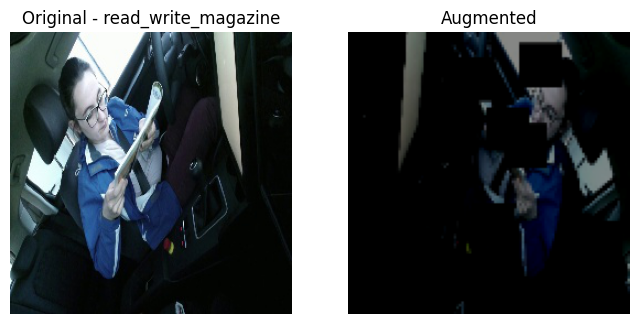

In [31]:
import pandas as pd
import random

# 读 CSV
df = pd.read_csv('index.csv')

# 随机选一行
row = df.sample(1).iloc[0]
img_path = row.img_path
label = row.label

# 用 OpenCV 读图
img = cv2.imread(img_path)  # 注意是 BGR 格式
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 转成 RGB 方便 matplotlib 显示

# 应用增强
aug_img = augment(image=img)['image']

# 可视化对比
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f"Original - {label}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(aug_img)
plt.title("Augmented")
plt.axis('off')

plt.show()

## 阶段 4：批量保存增强图像

In [32]:
### 创建输出目录

import os

output_dir = 'processed_data'
os.makedirs(output_dir, exist_ok=True)

print(f" 已创建输出目录: {output_dir}")

 已创建输出目录: processed_data


In [35]:
from tqdm import tqdm
import cv2
import pandas as pd

# 重新读 index.csv
df = pd.read_csv('index.csv')

# 增强 pipeline（你可以把这里替换成调好参数的 augment 变量）
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
    A.CoarseDropout(max_holes=8, max_height=40, max_width=40, fill_value=0, p=0.5),
    A.Resize(112, 112)
])

for i, row in tqdm(df.iterrows(), total=len(df), desc='Saving augmented images'):
    img_path = row.img_path
    label = row.label

    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ 读取失败: {img_path}")
        continue

    img_aug = augment(image=img)['image']

    # 新文件名：label_原文件名
    new_fname = f"{label}_{os.path.basename(img_path)}"
    save_path = os.path.join(output_dir, new_fname)

    cv2.imwrite(save_path, img_aug)

print(f" 批量增强完成，保存到 {output_dir}")


Saving augmented images: 100%|█████████| 243779/243779 [06:26<00:00, 630.36it/s]

 批量增强完成，保存到 processed_data


In [36]:
import os, re, shutil
from tqdm import tqdm

src_dir = 'processed_data'
dst_dir = 'processed_data_by_class'
os.makedirs(dst_dir, exist_ok=True)

pattern = re.compile(r'^(.+?)_image_\d+\.[^.]+$')   # 仅匹配标准命名

for fname in tqdm(os.listdir(src_dir), desc='按 label 分类'):
    if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    m = pattern.match(fname)
    if not m:
        print(' 文件名不符合规则，已跳过：', fname)
        continue

    label = m.group(1)                               # 完整 label
    class_dir = os.path.join(dst_dir, label)
    os.makedirs(class_dir, exist_ok=True)

    src_path = os.path.join(src_dir, fname)
    dst_path = os.path.join(class_dir, fname)

    if not os.path.exists(dst_path):
        shutil.copy2(src_path, dst_path)                  # 或 shutil.copy2 / os.symlink

print(' 整理完成：processed_data_by_class/ 下已按完整标签分类。')


按 label 分类: 100%|██████████████████| 243779/243779 [01:18<00:00, 3121.40it/s]

 整理完成：processed_data_by_class/ 下已按完整标签分类。


In [34]:
import os
import pandas as pd
from tqdm import tqdm

df = pd.read_csv('index.csv')
src_dir = 'processed_data'
dst_dir = 'processed_data_by_class'
os.makedirs(dst_dir, exist_ok=True)

missing_count = 0

for _, row in tqdm(df.iterrows(), total=len(df)):
    orig_fname = os.path.basename(row.img_path)
    src_path = os.path.join(src_dir, orig_fname)
    label = row.label

    if not os.path.exists(src_path):
        if missing_count < 20:
            print(f" 未找到: {src_path}")
        missing_count += 1
        continue

    class_dir = os.path.join(dst_dir, label)
    os.makedirs(class_dir, exist_ok=True)

    dst_path = os.path.join(class_dir, orig_fname)
    os.rename(src_path, dst_path)

print(f" 整理完成！共 {missing_count} 个文件未找到。")


  2%|▌                                 | 4439/243779 [00:00<00:10, 23438.08it/s]

 未找到: processed_data/image_0.jpg
 未找到: processed_data/image_1.jpg
 未找到: processed_data/image_2.jpg
 未找到: processed_data/image_3.jpg
 未找到: processed_data/image_4.jpg
 未找到: processed_data/image_5.jpg
 未找到: processed_data/image_6.jpg
 未找到: processed_data/image_7.jpg
 未找到: processed_data/image_8.jpg
 未找到: processed_data/image_9.jpg
 未找到: processed_data/image_10.jpg
 未找到: processed_data/image_11.jpg
 未找到: processed_data/image_12.jpg
 未找到: processed_data/image_13.jpg
 未找到: processed_data/image_14.jpg
 未找到: processed_data/image_15.jpg
 未找到: processed_data/image_16.jpg
 未找到: processed_data/image_17.jpg
 未找到: processed_data/image_18.jpg
 未找到: processed_data/image_19.jpg


100%|████████████████████████████████| 243779/243779 [00:05<00:00, 40694.49it/s]

 整理完成！共 243779 个文件未找到。


## 阶段 5：训练前验证 / DataLoader 测试

In [38]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# 用 ImageFolder 自动识别 'label_' 前缀
dataset = ImageFolder(
    root='processed_data_by_class',
    loader=lambda path: cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB),
    transform=transforms.ToTensor()
)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 取一个 batch 看 shape 和 label
images, labels = next(iter(dataloader))
print(f"Batch images shape: {images.shape}")  # 应该是 [4, 3, 112, 112]
print(f"Batch labels: {labels}")


Batch images shape: torch.Size([4, 3, 112, 112])
Batch labels: tensor([11,  0,  4,  8])
